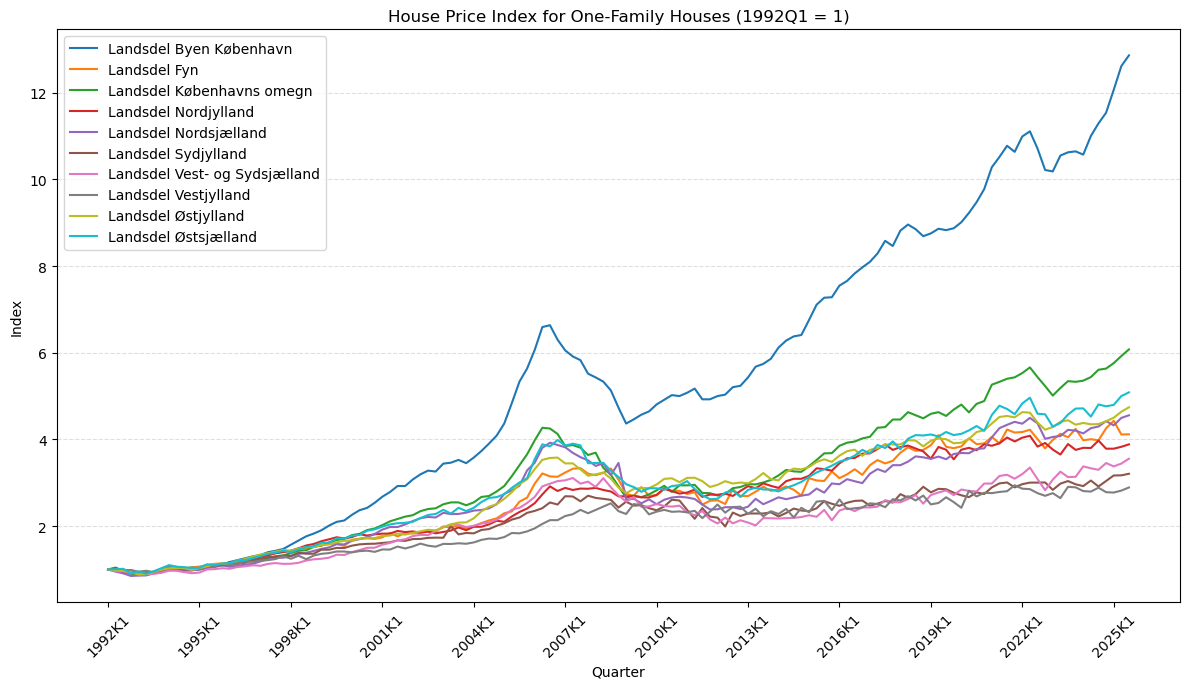

Total house price growth since 1992Q1:
OMRÅDE
Landsdel Byen København          11.860215
Landsdel Københavns omegn         5.076503
Landsdel Østsjælland              4.085308
Landsdel Østjylland               3.741071
Landsdel Nordsjælland             3.556034
Landsdel Fyn                      3.117409
Landsdel Nordjylland              2.884921
Landsdel Vest- og Sydsjælland     2.554517
Landsdel Sydjylland               2.206587
Landsdel Vestjylland              1.891061
Name: 2025K3, dtype: float64


In [ ]:
# Question 1.1 - Real House Price Evolution (Indexed)

import pandas as pd
import matplotlib.pyplot as plt
from dstapi import DstApi


# 1. Download data from DST
api = DstApi("EJ56")

params = {
    "table": "EJ56",
    "format": "BULK",
    "lang": "da",
    "variables": [
        {"code": "OMRÅDE", "values": ["*"]},
        {"code": "EJENDOMSKATE", "values": ["2103"]},  # Owned houses
        {"code": "TAL", "values": ["100"]},           # Index
        {"code": "Tid", "values": ["*"]},
    ],
}

df_raw = api.get_data(params=params)


# Clean data

df_raw["INDHOLD"] = pd.to_numeric(
    df_raw["INDHOLD"]
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)


# 3. Pivot to wide format

wide = (
    df_raw
    .pivot(index="TID", columns="OMRÅDE", values="INDHOLD")
    .sort_index()
)

# Keep only provinces 
wide = wide[[c for c in wide.columns if c.startswith("Landsdel")]]

# From 1992Q1 onward
wide = wide.loc["1992K1":]

# Drop incomplete series
wide = wide.dropna(axis=1)

# Indexing with base year = 1
final_data = wide / wide.iloc[0]


# 4. Plot
plt.figure(figsize=(12, 7))

for col in final_data.columns:
    plt.plot(final_data.index, final_data[col], label=col)

plt.title("House Price Index for One-Family Houses (1992Q1 = 1)")
plt.xlabel("Quarter")
plt.ylabel("Index")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# X-axis: 1992Q1, then every 3 years
ticks = list(range(0, len(final_data.index), 12))
labels = final_data.index[ticks]
plt.xticks(ticks, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Ranking
ranking = (final_data.iloc[-1] - 1).sort_values(ascending=False)
print("Total house price growth since 1992Q1:")
print(ranking)


The analysis highlights a major geographic divergence. Provinces near Copenhagen ('Landsdel Byen København', 'Københavns omegn') show 
exponential price growth compared to rural areas since 1992.

Calculating Real Prices using data from Question 1.1


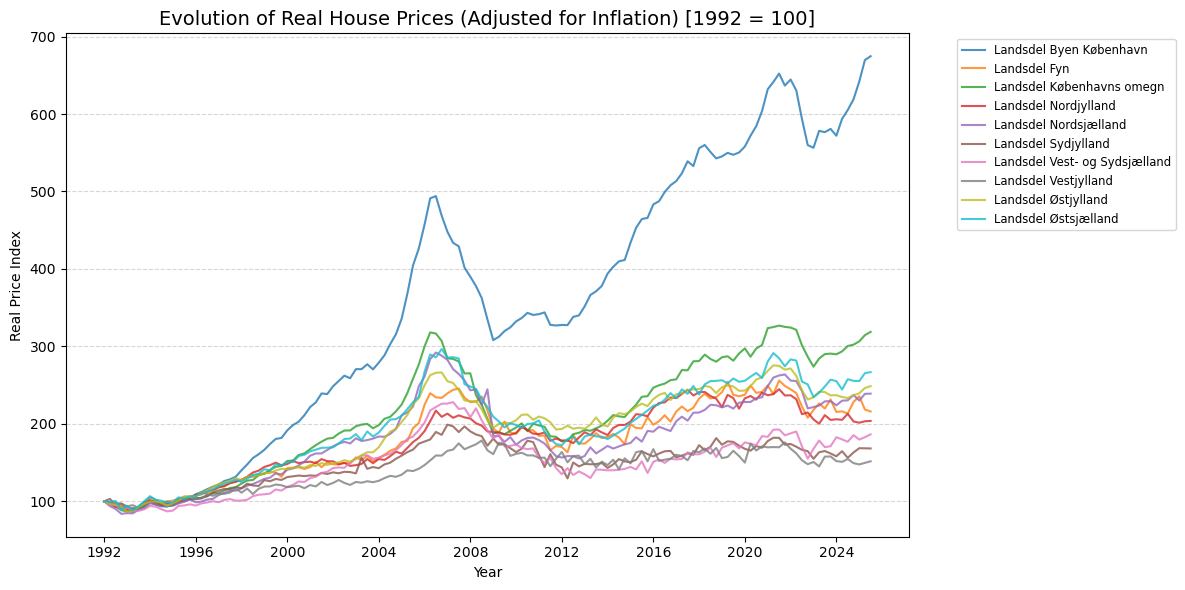


Ranking of Provinces by Total Real House Price Growth (Since 1992-Q1):
OMRÅDE
Landsdel Byen København          574.65
Landsdel Københavns omegn        218.78
Landsdel Østsjælland             166.78
Landsdel Østjylland              148.72
Landsdel Nordsjælland            139.01
Landsdel Fyn                     116.00
Landsdel Nordjylland             103.80
Landsdel Vest- og Sydsjælland     86.47
Landsdel Sydjylland               68.22
Landsdel Vestjylland              51.67
Name: 2025-07-01 00:00:00, dtype: float64


In [18]:
# Question 1.2 - Real House Price Evolution (Indexed)

# 1. Fetching the required data
# Helper function to get quarterly CPI data using DSTAPI
def get_cpi_quarterly():

    api = DstApi("PRIS113")

    params = {
        "table": "PRIS113",
        "format": "BULK",
        "lang": "da",
        "variables": [
            {"code": "TYPE", "values": ["INDEKS"]},
            {"code": "Tid", "values": ["*"]},
        ],
    }

    df = api.get_data(params=params)

    # Clean numeric values (DST uses comma decimals and ".." for missing)
    df["CPI"] = pd.to_numeric(
    df["INDHOLD"]
        .astype(str)                  
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)


    # Convert monthly time format (e.g. 2022M01) to datetime
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")

    # CPI is monthly, house prices are quarterly
    # Take quarterly average CPI
    return df.set_index("Date")["CPI"].resample("QS").mean()

# 2. Calculate and Plot

print("Calculating Real Prices using data from Question 1.1")

# Reuse the house price data from Question 1.1
df_nominal = final_data.copy()

# Convert quarterly strings (e.g. 1992K1) to datetime
df_nominal.index = pd.to_datetime(
    [f"{x[:4]}-{int(x[5]) * 3 - 2:02d}-01" for x in df_nominal.index]
)

# Get CPI data
df_cpi = get_cpi_quarterly()

# Align the two datasets
common_idx = df_nominal.index.intersection(df_cpi.index)
df_nominal = df_nominal.loc[common_idx]
cpi_series = df_cpi.loc[common_idx]

# Calculate real house prices
# Formula: Nominal Price / CPI
df_real = df_nominal.div(cpi_series, axis=0)

# Re-index so all series start at 100 in 1992Q1
df_real_indexed = (df_real / df_real.iloc[0]) * 100

# Plot the results
plt.figure(figsize=(12, 6))
for col in df_real_indexed.columns:
    plt.plot(df_real_indexed.index, df_real_indexed[col], label=col, linewidth=1.5, alpha=0.8)

plt.title("Evolution of Real House Prices (Adjusted for Inflation) [1992 = 100]", fontsize=14)
plt.ylabel("Real Price Index")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Print ranking
print("\nRanking of Provinces by Total Real House Price Growth (Since 1992-Q1):")
print((df_real_indexed.iloc[-1] - 100).sort_values(ascending=False).round(2))


Processing Real Prices for Municipalities...
Correlation between Initial Level and Total Growth: 0.8135


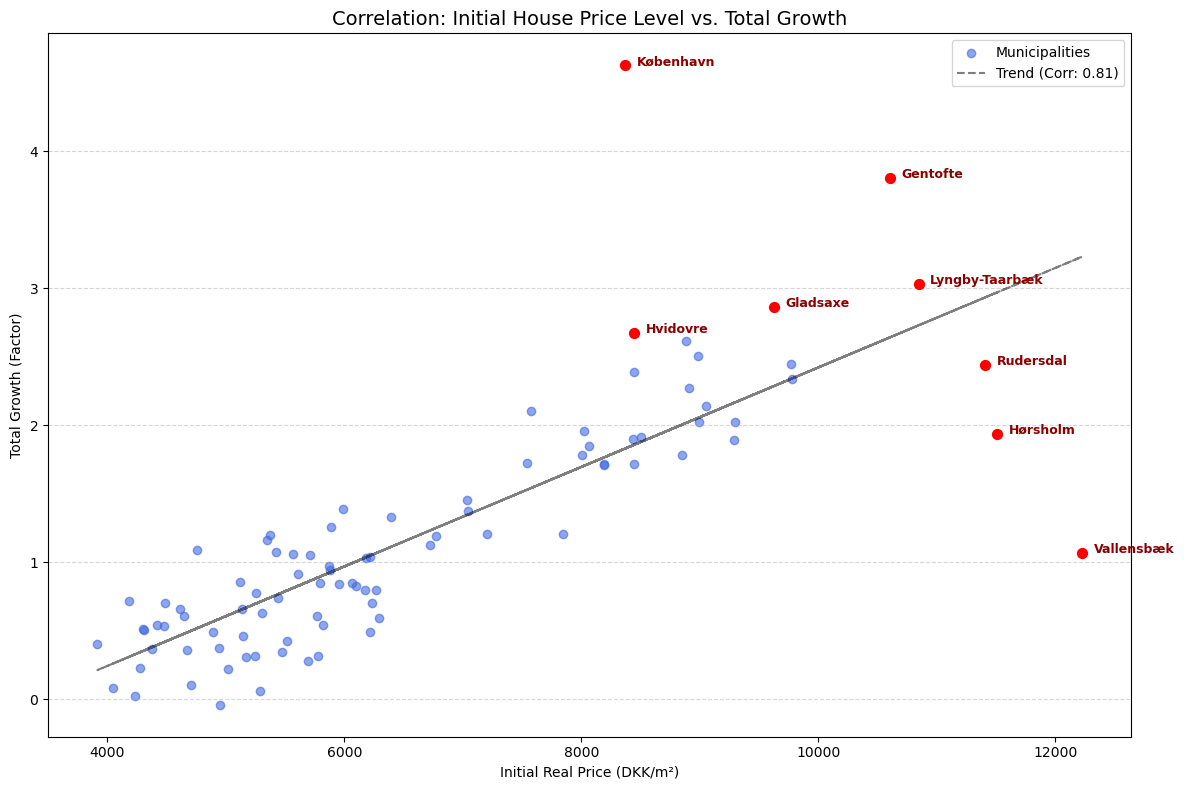

In [19]:
# Question 1.3 - Real House Prices per m² (Municipalities)

import os
import numpy as np

# 1. Load Excel Data
def load_excel_data(filename="BM010_houses.xlsx"):
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()
    file_path = os.path.join(script_dir, filename)

    df = pd.read_excel(file_path, header=None)
    header_row = df.iloc[2].copy()
    header_row[2] = "Area"
    df.columns = header_row
    df = df.iloc[3:].copy()

    df["Area"] = df["Area"].astype(str).str.strip()
    df = df.set_index("Area")

    date_cols = [c for c in df.columns if isinstance(c, str) and "Q" in c]
    df = df[date_cols]

    date_map = {}
    for col in df.columns:
        year = int(col[:4])
        quarter = int(col[5])
        month = quarter * 3 - 2
        date_map[col] = pd.to_datetime(f"{year}-{month:02d}-01")

    df = df.rename(columns=date_map)
    return df.T.apply(pd.to_numeric, errors="coerce")


# 2. Fetch CPI Data 
def get_cpi_data():
    api = DstApi("PRIS113")

    params = {
        "table": "PRIS113",
        "format": "BULK",
        "lang": "da",
        "variables": [
            {"code": "TYPE", "values": ["INDEKS"]},
            {"code": "Tid", "values": ["*"]},
        ],
    }

    df = api.get_data(params=params)

    # Clean numeric values 
    df["CPI"] = pd.to_numeric(
        df["INDHOLD"]
            .astype(str)
            .replace("..", pd.NA)
            .str.replace(",", ".", regex=False),
        errors="coerce"
    )

    # Convert monthly format 
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")

    # Convert monthly CPI to quarterly frequency
    return df.set_index("Date")["CPI"].resample("QS").mean()


# 3. Execution

print("Processing Real Prices for Municipalities...")

# Create variables
df_muni_nominal = load_excel_data()
cpi = get_cpi_data()

# Clean Data (Drop missing columns)
df_muni_clean = df_muni_nominal.dropna(axis=1, how="any")

# Align and calculate Real Prices
common_idx = df_muni_clean.index.intersection(cpi.index)
df_muni_clean = df_muni_clean.loc[common_idx]
cpi_aligned = cpi.loc[common_idx]

# Save as 'df_muni_real' (Important for Q1.4)
df_muni_real = df_muni_clean.div(cpi_aligned, axis=0) * 100

# Correlation Analysis
initial_level = df_muni_real.iloc[0]
latest_level = df_muni_real.iloc[-1]
total_growth = (latest_level - initial_level) / initial_level
correlation = initial_level.corr(total_growth)

print(f"Correlation between Initial Level and Total Growth: {correlation:.4f}")

# Identify Labels (Top 5 Growth + Top 5 Initial Level)
top_5_growth = total_growth.sort_values(ascending=False).head(5).index.tolist()
top_5_initial = initial_level.sort_values(ascending=False).head(5).index.tolist()

labels_to_show = list(set(top_5_growth + top_5_initial))

# 4. Plotting
plt.figure(figsize=(12, 8))

plt.scatter(initial_level, total_growth, alpha=0.6, color="royalblue", label="Municipalities")

for area in labels_to_show:
    x_val = initial_level[area]
    y_val = total_growth[area]
    plt.scatter(x_val, y_val, color="red", s=50, zorder=5)
    plt.text(x_val + 100, y_val, area, fontsize=9, color="darkred", weight="bold")

z = np.polyfit(initial_level, total_growth, 1)
p = np.poly1d(z)
plt.plot(initial_level, p(initial_level), "k--", alpha=0.5,
         label=f"Trend (Corr: {correlation:.2f})")

plt.title("Correlation: Initial House Price Level vs. Total Growth", fontsize=14)
plt.xlabel("Initial Real Price (DKK/m²)")
plt.ylabel("Total Growth (Factor)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


The correlation coefficient is approximately 0.81. This indicates a strong positive relationship.
Municipalities that had higher house prices in 1992 (the initial level) generally experienced much higher percentage growth over the
following decades compared to those that started with lower prices.

Analyzing recovery since the 2008 crisis...

Summary:
- Municipalities BELOW 2008 Peak: 83
- Municipalities ABOVE 2008 Peak: 9


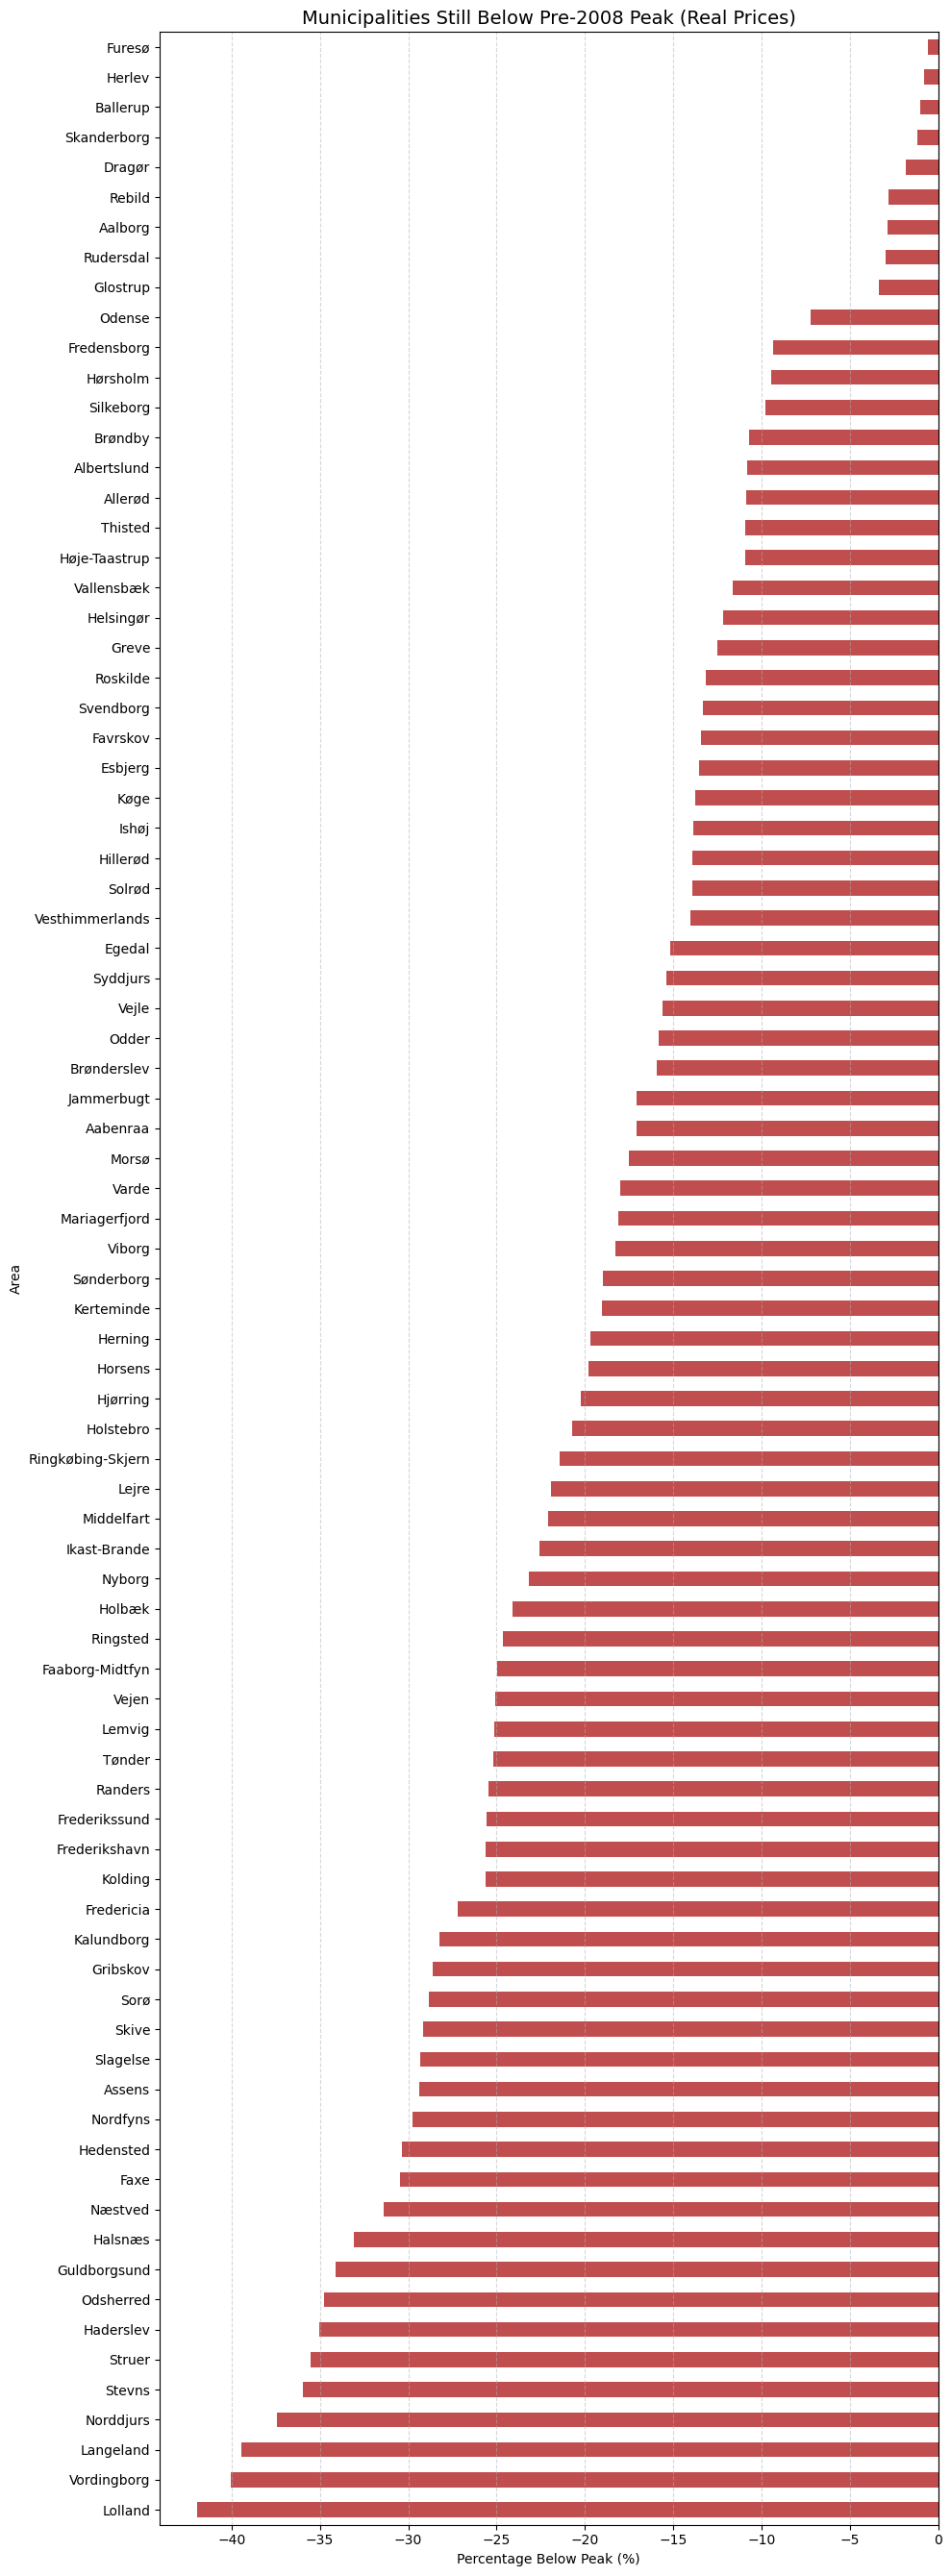


--- List: Municipalities BELOW Peak ---
Area
Lolland       -41.97
Vordingborg   -40.05
Langeland     -39.42
Norddjurs     -37.45
Stevns        -35.98
               ...  
Dragør         -1.82
Skanderborg    -1.16
Ballerup       -1.02
Herlev         -0.77
Furesø         -0.60
Length: 83, dtype: float64


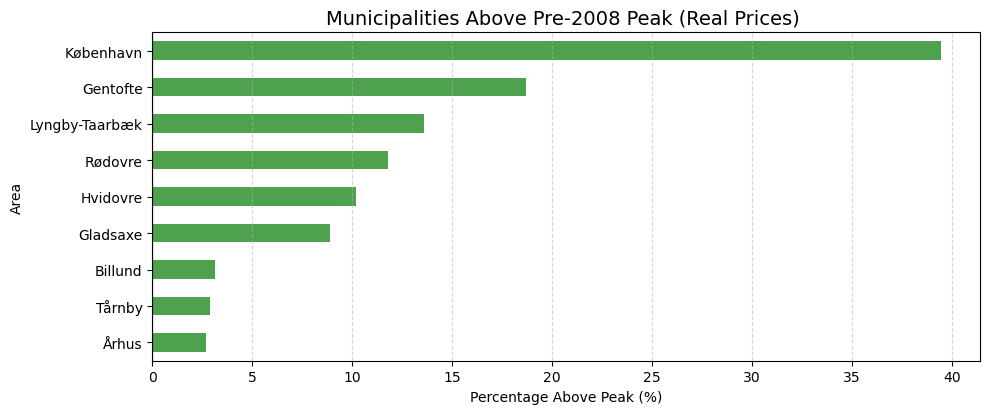


--- List: Municipalities ABOVE Peak (Top 10) ---
Area
København         39.44
Gentofte          18.72
Lyngby-Taarbæk    13.60
Rødovre           11.78
Hvidovre          10.17
Gladsaxe           8.89
Billund            3.16
Tårnby             2.87
Århus              2.67
dtype: float64


In [20]:
# Question 1.4 - Recovery Analysis


# 1. Analyze the Recovery
print("Analyzing recovery since the 2008 crisis...")

# We grab the real prices we already calculated in Question 1.3
df = df_muni_real.copy()

# Smooth the data (4-Quarter Rolling Average)
# This removes short-term noise to reveal the true trend
df_rolling = df.rolling(window=4).mean()

# Find the "Pre-Crisis Peak"
# We look for the highest price each municipality reached before 2009
pre_crisis_data = df_rolling.loc[:'2008-12-31']
peaks = pre_crisis_data.max()

# Compare with today
# We take the very last available price in the dataset
latest_values = df_rolling.iloc[-1]

# Calculate the difference in percentage: (Today - Peak) / Peak
pct_diff = ((latest_values - peaks) / peaks) * 100

# Split the municipalities into two teams:
# Team 1: Still below their 2008 peak (Negative %)
below_peak = pct_diff[pct_diff < 0].sort_values()
# Team 2: Above their 2008 peak (Positive %)
above_peak = pct_diff[pct_diff >= 0].sort_values()

print(f"\nSummary:")
print(f"- Municipalities BELOW 2008 Peak: {len(below_peak)}")
print(f"- Municipalities ABOVE 2008 Peak: {len(above_peak)}")


# 2. Plotting

# Plot 1: The "Struggling" Areas (Below Peak)
if not below_peak.empty:
    # Adjust chart height based on how many areas are in the list
    plt.figure(figsize=(10, len(below_peak) * 0.3 + 2)) 
    below_peak.plot(kind='barh', color='firebrick', alpha=0.8)

    plt.title("Municipalities Still Below Pre-2008 Peak (Real Prices)", fontsize=14)
    plt.xlabel("Percentage Below Peak (%)")
    plt.axvline(0, color='black', linewidth=0.8) 
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- List: Municipalities BELOW Peak ---")
    print(below_peak.round(2))
else:
    print("\nNo municipalities are below their pre-2008 peak.")


# Plot 2: The "Recovered" Areas (Above Peak)
if not above_peak.empty:
    # Adjust chart height, but cap it so it doesn't get infinite
    height = min(len(above_peak) * 0.25 + 2, 25)
    plt.figure(figsize=(10, height)) 
    
    # If the list is huge, we just show the top 40 to keep it readable
    if len(above_peak) > 50:
        plot_data = above_peak.tail(40) 
        title_suffix = "(Top 40 Shown)"
    else:
        plot_data = above_peak
        title_suffix = ""

    plot_data.plot(kind='barh', color='forestgreen', alpha=0.8)

    plt.title(f"Municipalities Above Pre-2008 Peak (Real Prices) {title_suffix}", fontsize=14)
    plt.xlabel("Percentage Above Peak (%)")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- List: Municipalities ABOVE Peak (Top 10) ---")
    print(above_peak.sort_values(ascending=False).head(10).round(2))